###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.

# Spreading out

You've reached the fourth module of the open course [**"Practical Numerical Methods with Python"**](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about), titled *Spreading out: Parabolic PDEs*. We hope that you are enjoying the ride of [#numericalmooc](https://twitter.com/hashtag/numericalmooc) so far!

We introduced finite-difference methods for partial differential equations (PDEs) in the [second module](https://github.com/numerical-mooc/numerical-mooc/tree/master/lessons/02_spacetime), and looked at convection problems in more depth in [module 3](https://github.com/numerical-mooc/numerical-mooc/tree/master/lessons/03_wave). Now we'll look at solving problems dominated by diffusion.

Why do we separate the discussion of how to solve convection-dominated and diffusion-dominated problems, you might ask? It's all about the harmony between mathematical model and numerical method. Convection and diffusion are inherently different physical processes.

The titles of the course modules are meant to spark your imagination: 

* _Riding the wave_—imagine a surfer on a tall wave, moving fast towards the beach ... convection implies transport, speed, direction. The physics has a directional bias, and we discovered that numerical methods should be compatible with that. That's why we use _upwind_ methods for convection, and we pay attention to problems where waves move in opposite directions, needing special schemes.

* _Spreading out_—now imagine a drop of food dye in a cup of water, slowly spreading in all directions until all the liquid takes a uniform color. [Diffusion](http://en.wikipedia.org/wiki/Diffusion) spreads the concentration of something around (atoms, people, ideas, dirt, anything!). Since it is not a directional process, we need numerical methods that are isotropic (like central differences).

In [1]:
from IPython.display import Image
Image(url='http://upload.wikimedia.org/wikipedia/commons/f/f9/Blausen_0315_Diffusion.png')

## Parabolic PDEs

You already met the simplest parabolic PDE—the [1-D diffusion equation](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_03_1DDiffusion.ipynb)—in module 2. Its main feature is that it has a second-order derivative in space. Here it is again:

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

Check out the article on [parabolic PDEs](http://en.wikipedia.org/wiki/Parabolic_partial_differential_equation) in Wikipedia. Now compare with the diffusion equation above, with the two independent variables here being $x, t$. You'll see that with no mixed derivatives, and only one second-order derivative (in the spatial variable $x$), it satisfies the condition of a parabolic PDE. Work it out on a piece of paper if you need to.

In the previous module, discussing hyperbolic conservation laws, we learned that solutions have characteristics: information travels along certain paths on space-time phase space. In contrast, parabolic equations don't have characteristics, because any local change in the initial condition will eventually affect the entire domain, although its effect will be felt at smaller intensity with longer distances. This is typical of diffusion processes.


In this first lesson of the module, we first review the 1D diffusion equation and then take a deeper look into the issue of boundary conditions. In the next notebook, we'll introduce _implicit discretizations_ for the first time, which will take us to the land of linear solvers. In the third lesson we'll graduate to two dimensions—more boundary condition and stability issues will come up. We'll then study 2D implicit methods, and go into Crank-Nicolson method: perhaps the most popular of them all. _Enjoy!_

## Heat conduction

Heat conduction is a diffusive process. Let's remind ourselves of the heat equation in one spatial dimension:

\begin{equation}
\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2}
\end{equation}

Here, $\alpha$ is the thermal diffusivity, a property of the material, and $T$ is the temperature.

In the [third lesson of module 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_03_1DDiffusion.ipynb), we discretized the diffusion equation  with a forward-time, centered-space scheme, subject to the following stability constraint:

\begin{equation}
\alpha \frac{\Delta t}{(\Delta x)^2} \leq \frac{1}{2}
\end{equation}

Let's look into it more deeply now, using a 1D temperature-evolution problem.

### Problem set up

Say we have a graphite rod, with [thermal diffusivity](http://en.wikipedia.org/wiki/Thermal_diffusivity) of $\alpha=1.22\times10^{-3} {\rm m}^2/{\rm s}$, length $L=1{\rm m}$, and temperature $T=0{\rm C}$ everywhere. At time $t=0$, we raise the temperature on the left-side end, $x=0$, to $T=100{\rm C}$, and hold it there. *How will the temperature evolve in the rod?*

As usual, start by importing some libraries and setting up the discretization. We'll begin by using a spatial grid with 51 points and advance for 100 time steps, using a forward-time/centered scheme.

![graphite-rod](./figures/graphite-rod.png)
.
#### Figure 1. Graphite rod, temperature fixed on ends.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
L = 1
nt = 100
nx = 51
alpha = 1.22e-3

dx = L/(nx-1)

Ti = numpy.zeros(nx)
Ti[0] = 100

Remember the forward-time, centered-space discretization? You should work it out on a piece of paper yourself (if you can't do it without looking it up, it means you need to do this more!).

\begin{equation}\frac{T_{i}^{n+1}-T_{i}^{n}}{\Delta t}=\alpha\frac{T_{i+1}^{n}-2T_{i}^{n}+T_{i-1}^{n}}{\Delta x^2}\end{equation}

To obtain the temperature at the next time step, $T^{n+1}_i$, from the known information at the current time step, we compute

\begin{equation}T_{i}^{n+1}=T_{i}^{n}+\frac{\alpha\Delta t}{\Delta x^2}(T_{i+1}^{n}-2T_{i}^{n}+T_{i-1}^{n})\end{equation}

Check the [third notebook of module 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_03_1DDiffusion.ipynb), if you need to refresh your memory!

The following function implements this numerical scheme:

In [3]:
def ftcs(T, nt, dt, dx, alpha):
    """Solves the diffusion equation with forward-time, centered scheme
    
    Parameters:
    ----------
    T: array of float
        Initial temperature profile
    nt: int
        Number of time steps
    dt: float
        Time step size
    dx: float
        Mesh size
    alpha: float
        Diffusion coefficient (thermal diffusivity)
        
    Returns:
    -------
    T: array of float
        Temperature profile after nt time steps with forward in time scheme
    
    """
    
    for n in range(nt):  
        Tn = T.copy() 
        T[1:-1] = Tn[1:-1] + alpha*dt/dx**2*(Tn[2:] -2*Tn[1:-1] + Tn[0:-2])
        
        
    return T

We are all set to run! First, let's use a time step `dt` that satisfies the stability constraint

In [4]:
sigma = 1/2.0
dt = sigma * dx*dx/alpha
T = ftcs(Ti.copy(), nt, dt, dx, alpha)

##### Note
-----
We are sending a *copy* of `Ti` to the function `ftcs`.  Sending a copy insures that the value of `Ti` remains unchanged for us to reuse.  

Confused?  Take a look at [Lesson 0](./04_00_Python_Function_Quirks.ipynb) for a more in-depth explanation.
 
 -----

Now plot the solution!

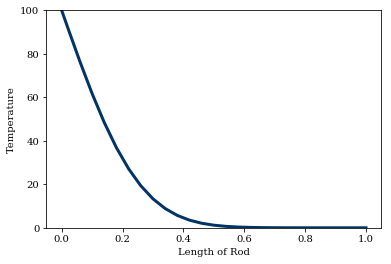

In [5]:
pyplot.plot(numpy.linspace(0,1,nx), T, color='#003366', ls='-', lw=3)
pyplot.ylim(0,100)
pyplot.xlabel('Length of Rod')
pyplot.ylabel('Temperature');

## Boundary Conditions

In the rod problem above, we stated that the left-hand side of the rod is held to a temperature $T = 100{\rm C}$.  This is an example of a *boundary condition* (BC): a rule that defines how the problem interacts with the borders of the domain.  In this case, the domain spans the length of the rod, from $0 \leq x \leq 1$.

There are many types of boundary conditions, and they have an important effect on the solution of the problem. For example, in [module 2, lesson 4](http://nbviewer.ipython.org/urls/raw.github.com/numerical-mooc/numerical-mooc/master/lessons/02_spacetime/02_04_1DBurgers.ipynb) on Burgers' Equation, we used a periodic boundary condition to "connect" the right-hand and left-hand borders of the domain.  

We need to discuss boundary conditions in a little more detail, and this is good place to do it. Read on!

### Dirichlet boundary

The rod example above uses a *Dirichlet* BC on the left-hand side.  A Dirichlet boundary is one in which the border is held to a specific value of the solution variable.

What about the right-hand end of the rod $(x=1)$?  In the discretization we set up above, the problem hasn't evolved for long enough time for the heat to travel the full length of the rod.  Let's increase the number of timesteps, `nt`, and see what happens.

In [7]:
nt = 1000
T = ftcs(Ti.copy(), nt, dt, dx, alpha)

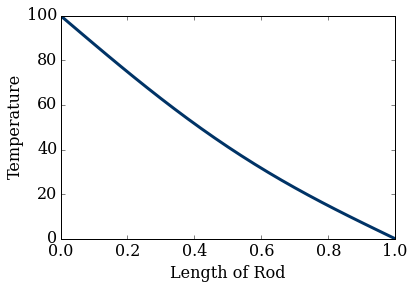

In [8]:
pyplot.plot(numpy.linspace(0,1,nx), T, color='#003366', ls='-', lw=3)
pyplot.ylim(0,100)
pyplot.xlabel('Length of Rod')
pyplot.ylabel('Temperature');

Hmmm ... it looks like we're pinning the right BC to the value $T=0{\rm C}$, do you agree?
Now study the code for the `ftbs` function, above, and try to figure out what happens at the right-most point of the spatial grid. 

Did you figure it out? 

It never updates the value at `T[-1]`!  That value is set to zero in the initial condition and stays that way throughout the entire simulation.  We effectively have a Dirichlet boundary at *both* ends.  The left-hand side of the rod is held to a temperature of $T = 100{\rm C}$ and the right-hand side is held to $T = 0{\rm C}$  Because both end tempera- tures are "pinned" to set values, the temperature distribution within the rod will relax (after enough time) to a linear temperature gradient across the length of the rod.  

Once the solution is relaxed, no number of extra timesteps will make it change.  This is an example of a *steady-state solution* and we'll learn more about those in Module 5 of the course.

Dirichlet BCs show up in many engineering applications, among them thermo- dynamics (e.g., setting a surface temperature) and fluid dynamics (e.g., the no-slip conditions at walls in viscous fluids).

### Neumann boundary

Another commonly used BC is the *Neumann* boundary: rather than specifying the value of the solution at the border, they specify the value of the *derivative* of the solution at the border.  

In our example, if we apply a Neumann boundary to the right-hand end of the rod, we can represent that mathematically as

\begin{equation}
\left. \frac{\partial T}{\partial x} \right|_{x = 1} = q(t)
\end{equation}

How can we enforce that in code?  One easy way is using a finite-difference discretization of the derivative at the boundary.  At time step $n$, for $N$ points, that would be

\begin{equation}
\left. \frac{\partial T}{\partial x} \right|_{x=1} \approx \frac{T^n_N - T^n_{N-1}}{\Delta x} = q(t)
\end{equation}

In the context of heat conduction, the space derivative of temperature is the heat flux density $q$, the amount of heat per unit time, per unit area.

For example, if the rod at $x=1$ has some insulating material, no heat is going to be able to get out through that end, and the Neumann boundary condition is:

\begin{equation}
\left. \frac{\partial T}{\partial x} \right|_{x=1} = 0
\end{equation}

Think about what the equation is saying: the change in temperature when moving in the $x$ direction is zero at the right-most edge of the rod. That means that the temperature should be equal on the last two spatial grid points.

To enforce this Neumann boundary condition at the right-hand end of the rod, we add the following line of code:

```Python
T[-1] = T[-2]
```

That is, the temperature at the boundary (`T[-1]`) is equal to the temperature directly to its left (`T[-2]`).  The spatial gradient is zero and a Neumann condition is satisfied there.


The Dirichlet conditions in the rod example were enforced without any extra input from us, but the Neumann condition will require an update at each iteration of the loop.

Finally, Dirichlet and Neumann BCs can sometimes be mixed to better represent the physics of a problem.  

Let's revisit the heated-rod problem.  This time, the temperature at $x = 0$ will remain fixed at $T = 100{\rm C}$—that's the Dirichlet condition— and a Neumann BC applies at $x = 1$.


In [9]:
def ftcs_mixed(T, nt, dt, dx, alpha):
    """Solves the diffusion equation with forward-time, centered scheme using
    Dirichlet b.c. at left boundary and Neumann b.c. at right boundary
    
    Parameters:
    ----------
    u: array of float
        Initial temperature profile
    nt: int
        Number of time steps
    dt: float
        Time step size
    dx: float
        Mesh size
    alpha: float
        Diffusion coefficient (thermal diffusivity)
        
    Returns:
    -------
    u: array of float
        Temperature profile after nt time steps with forward in time scheme
    
    """
    for n in range(nt):  
        Tn = T.copy() 
        T[1:-1] = Tn[1:-1] + alpha*dt/dx**2*(Tn[2:] -2*Tn[1:-1] + Tn[0:-2])
        T[-1] = T[-2]
        
    return T

In [10]:
nt = 1000
T = ftcs_mixed(Ti.copy(), nt, dt, dx, alpha)

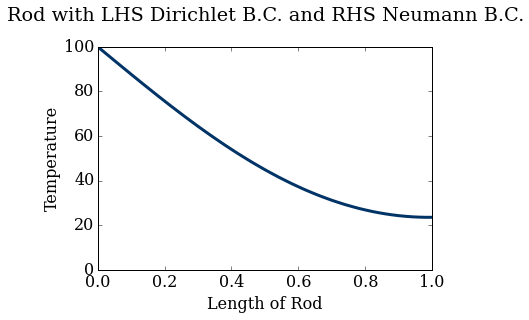

In [11]:
pyplot.plot(numpy.linspace(0,1,nx), T, color='#003366', ls='-', lw=3)
pyplot.ylim(0,100)
pyplot.title('Rod with LHS Dirichlet B.C. and RHS Neumann B.C.\n')
pyplot.xlabel('Length of Rod')
pyplot.ylabel('Temperature');

Now heat is accumulating in the domain. Our insulator works!  If you increase the number of timesteps `nt` further, you will see that the outflow temperature at $x = 1$ continues to increase.  

### Explicit schemes and BCs

The numerical schemes we've learned so far are called _explicit_, because we compute the updated solution at $t^{n+1}$ using only known information at time $t^n$. This is simple but has limitations, particularly with the small sizes of time step necessary to obtain stability.

Here's another issue with explicit schemes. Figure 2 shows the superposed stencil of several grid points over three time steps computed using the forward-time, centered scheme. You know that to calculate $T_i^{n+1}$ you use the information from the grid points $i-1, i, i+1$ at the previous time step. Think about what happens at the boundary: any change in the boundary condition will feed into the solution only at the next time step, not immediately. But this contradicts the physics of the problem, as any change on the boundary should be felt right away under the diffusion equation. To include boundary effects on the same time level, we can use an _implicit_ update (subject of the next lesson).

![explicitFTCS-BCeffect](./figures/explicitFTCS-BCeffect.png)
.
#### Figure 2. Stencil with explicit scheme over 3 time steps.

### Explicit schemes and time step

Let's replace the parameter $\sigma=\alpha \frac{\Delta t}{(\Delta x)^2}$ into Equation 4 and rearrange it a little bit, grouping together the terms at grid point $i$ on the right-hand side:


\begin{equation}
T_{i}^{n+1} = \sigma T_{i-1}^{n}+(1- 2 \sigma) T_{i}^{n} + \sigma T_{i+1}^{n}
\end{equation}

It's helpful to look at a sketch of the stencil for the heat equation with the weights added in for the contribution of each grid point. See Figure 3, which shows the weights for two values of $\sigma$: $\frac{1}{2}$ and $1$. Notice that with $\sigma=\frac{1}{2}$, the solution variable at the next time step is _independent_ from its own value at the present step, which seems a bit weird. And with $\sigma=1$, the current value affects negatively the future value—now _that's_ a red flag!

In fact, the solution will develop growing errors with $\sigma>\frac{1}{2}$, i.e., become unstable. This limits the time step that can be used quite significantly, because $\Delta t \propto (\Delta x)^2$. This is a serious cost of _explicit_ methods and an incentive to consider _implicit_ alternatives (next lesson).

![stencil-weights](./figures/stencil-weights.png)
.
#### Figure 3. Stencils for the heat equation with $\sigma= \frac{1}{2}, 1$.

---
###### The cell below loads the style of the notebook

In [12]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())